# Predicting Adoption Speed

## Introduction

The purpose of this notebook is to provide an analysis of which types of pets have the toughest time getting adopted. In this analysis we are only studying the adoptions of Dogs and cats.

## Business Understanding

Shelters need to know which pets take the longest time to get adopted, so that they can focus on pushing potential adopters towards those pets.

+ __Stakeholder:__ ASPCA 


+ __Importance of Predictions:__ Correctly identifying which pets will have trouble getting adopted can save pets from a lifetime in a cage or getting put to sleep in the worst case scenario.


+ __Deliverable:__ An analysis of the adoptability of different types of dogs and cats


+ __Type of model:__ An interpretable multiclassification model that can be used in conjunction with domain knowledge to boost the accuracy of predictions on a pet's adoptability.

## Context

+ __False Positive:__ Predicting that a pet will get adopted within a month when it actually takes longer.


+ __False negative:__ Predicting that a pet will take longer than a month when  get adopted later than it actually gets adopted


+ __Which is Worse:__ False positive is worse because we would end up ignoring pets that need extra help getting adopted.

+ __Metric:__ 
    - __Precision__
    - Accuracy

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer, OrdinalEncoder, RobustScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, roc_auc_score, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

import warnings

warnings.filterwarnings('ignore')

### Functions used in the project

Use a function to instantly get the metrics from our models without repeating code\ This function was found at https://github.com/lindseyberlin/Cat-in-the-Dat-Project.git

In [31]:
def evaluate(estimator, X_tr, X_te, y_tr, y_te, roc_auc='skip'):
    #Create test and train preds
    tr_preds = estimator.predict(X_tr)
    te_preds = estimator.predict(X_te)
    
    # Set the rules for outputting roc_auc score  
    if roc_auc == 'skip': # skips calculating the roc_auc_score
        train_out = False
        test_out = False
    elif roc_auc == 'dec': 
        train_out = estimator.decision_function(X_train)
        test_out = estimator.decision_function(X_test)
    elif roc_auc == 'proba': 
        train_out = estimator.predict_proba(X_train)[:, 1] # proba for the 1 class
        test_out = estimator.predict_proba(X_test)[:, 1]
    else:
        raise Exception("The value for roc_auc should be 'skip', 'dec' or 'proba'")    
    
    '''Print out training scores for Accuracy, Precision, Recall, F1-Score
    Print out Roc_Auc socre if arguement was set to 'dec' or 'proba'    '''
    
    print("Training Scores:")
    print(f"Train Accuracy: {accuracy_score(y_tr, tr_preds)}")
    print(f"Train Precision: {precision_score(y_tr, tr_preds)}")
    print(f"Train Recall: {recall_score(y_tr, tr_preds)}")
    print(f"Train F1-Score: {f1_score(y_tr, tr_preds)}")
    if type(train_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_train, train_out)}")
        
    '''Print out the same metrics for test data'''
    
    print("*" * 10)
    print("Testing Scores:")
    print(f"Test Accuracy: {accuracy_score(y_te, te_preds)}")
    print(f"Test Precision: {precision_score(y_te, te_preds)}")
    print(f"Test Recall: {recall_score(y_te, te_preds)}")
    print(f"Test F1-Score: {f1_score(y_te, te_preds)}")
    if type(test_out) == np.ndarray: # checking for roc_auc
        print(f"ROC-AUC: {roc_auc_score(y_test, test_out)}")    
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(estimator, X_te, y_te, normalize='true')


## Data Understanding

- This data comes from the city of Bloomington's open data portal
- Most of the pets in this dataset have been adopted, thats why the focus is on adoption speed
- The target variable is 'duration of stay' which will be divided into 4 categories

###### These imports are saved csv files that I made after extensively cleaning the data in the [EDA notebook](https://github.com/wharr1203/BloomingtonPetAdoption/blob/main/1.EDA-Data%20Cleaning.ipynb).

In [3]:
cat_df = pd.read_csv('data/cat_df.csv')
dog_df = pd.read_csv('data/dog_df.csv')

## Data Exploration recap

In [4]:
cat_df['sexname'].value_counts()

Female     3598
Male       3341
Unknown     133
Name: sexname, dtype: int64

In [5]:
dog_df['sexname'].value_counts()

Male       2454
Female     1996
Unknown      20
Name: sexname, dtype: int64

The sex of both dogs and cats are pretty balanced

In [6]:
cat_df['age(months)'].value_counts()

6.0    201
1.0    162
3.0    112
2.0     79
4.0     65
5.0     58
Name: age(months), dtype: int64

We ahave over 500 kittens in our dataset.

In [7]:
dog_df['age(months)'].value_counts()

5.0    29
6.0    27
4.0    12
1.0     9
3.0     2
2.0     2
Name: age(months), dtype: int64

Not many puppies in this dataset, but we have almost 600 kittens.

In [8]:
cat_df['age(years)'].value_counts()

1.0     2580
2.0     1256
3.0     1052
0.0      677
4.0      390
5.0      269
6.0      171
7.0      160
8.0      116
10.0      96
9.0       61
11.0      57
12.0      45
13.0      39
14.0      30
15.0      26
16.0      26
17.0      12
18.0       6
19.0       3
Name: age(years), dtype: int64

In [9]:
dog_df['age(years)'].value_counts()

1.0     982
2.0     728
3.0     644
4.0     445
5.0     293
6.0     205
8.0     180
7.0     180
9.0     145
11.0    123
10.0    120
12.0    103
0.0      81
14.0     78
13.0     77
15.0     38
16.0     30
17.0      8
18.0      8
19.0      2
Name: age(years), dtype: int64

Most of the pets in this dataset are on the younger side of the scale.

## Data Cleaning Recap

+ Dropped columns that are outcomes or unrelated to the target.
+ The original dataset had over 20 different species so I narrowed it down to Dogs and Cats
+ Seperated the age into 2 columns, 1 for years and the second for months
+ Consolidated the basecoulour and breednames column
+ Subtracted the intake date from the movement date to create the target column that records how many days a pet has been in a shelter

### Prepare Dog Data for modeling

In [10]:
dog_df.head()

,Unnamed: 0,id,intakedate,intakereason,istransfer,identichipnumber,animalname,breedname,basecolour,speciesname,animalage,sexname,location,movementdate,movementtype,returndate,puttosleep,age(months),age(years),duration of stay
0,12,46238,2016-10-09 00:00:00,Abandoned,False,981020019070093,Tennessee,Heeler,Black and Brown,Dog,5 years 7 months,Male,Special Care Dogs,2018-02-14 00:00:00,Adoption,NaN,False,NaN,5.0,493.0
1,15,46693,2016-11-21 00:00:00,Abandoned,False,981020017897009,Baby,Pitbull,White,Dog,5 years 9 months,Male,Adoptable Dogs,2017-04-07 00:00:00,Adoption,NaN,False,NaN,5.0,137.0
2,19,47146,2017-01-17 00:00:00,Abandoned,False,981020021063793,Dinah,Labrador Retriever,Black,Dog,5 years 6 months,Female,Foster,2017-04-01 00:00:00,Adoption,NaN,False,NaN,5.0,74.0
3,27,47239,2017-01-27 00:00:00,Abandoned,False,981020021070452,Maria,NaN,Black and Brown,Dog,3 years 5 months,Female,Foster,2017-04-01 00:00:00,Adoption,NaN,False,NaN,3.0,64.0
4,33,47319,2017-02-05 00:00:00,other,False,NaN,Louise Vada,Pitbull,Black,Dog,4 years 5 months,Female,Stray Dogs Theta,2017-04-05 00:00:00,Reclaimed,NaN,False,NaN,4.0,59.0


In [12]:
dog_df['movementtype'].value_counts()

Adoption     2841
Reclaimed    1487
Transfer      107
Foster         34
Escaped         1
Name: movementtype, dtype: int64

There are only 34 fosters in this set and most of the fosters happen pretty quickly. Thats why I only use the entries that have adoptions as the movementtype. 

In [13]:
dog_model_data = dog_df[dog_df['movementtype'] == 'Adoption']

In [14]:
def create model data(data)

0

In [15]:
dog_model_data.describe()

,Unnamed: 0,id,age(months),age(years),duration of stay
count,2841.000000,2841.000000,65.000000,2841.000000,2841.000000
mean,8698.644843,62603.009152,5.061538,3.689194,53.449490
std,5244.246966,4842.666952,0.899252,3.221766,118.125138
min,12.000000,46238.000000,2.000000,0.000000,1.000000
25%,4123.000000,58835.000000,5.000000,1.000000,10.000000
50%,8203.000000,62340.000000,5.000000,3.000000,18.000000
75%,12722.000000,66193.000000,6.000000,5.000000,41.000000
max,18667.000000,71690.000000,6.000000,18.000000,1443.000000


Now I want to categorize my target column into these 2 values. 

- 0 — Pet took more than 21 days to get adopted after being listed.
- 1 — Pet took 21 days or less to get adopted.

In [16]:
dog_model_data['duration of stay'][dog_model_data['duration of stay'] <= 21] = 1
dog_model_data['duration of stay'][dog_model_data['duration of stay'] > 21] = 0

In [17]:
dog_model_data['duration of stay'].value_counts()

1.0    1574
0.0    1267
Name: duration of stay, dtype: int64

#### Modeless Prediction

In [128]:
dog_model_data['duration of stay'].value_counts(normalize=True)

1.0    0.55403
0.0    0.44597
Name: duration of stay, dtype: float64

###### If I said that every dog would take longer than 21 days to get adopted, I would be right 44% of the time. 

In [19]:
 dog_model_data.head()

,Unnamed: 0,id,intakedate,intakereason,istransfer,identichipnumber,animalname,breedname,basecolour,speciesname,animalage,sexname,location,movementdate,movementtype,returndate,puttosleep,age(months),age(years),duration of stay
0,12,46238,2016-10-09 00:00:00,Abandoned,False,981020019070093,Tennessee,Heeler,Black and Brown,Dog,5 years 7 months,Male,Special Care Dogs,2018-02-14 00:00:00,Adoption,NaN,False,NaN,5.0,0.0
1,15,46693,2016-11-21 00:00:00,Abandoned,False,981020017897009,Baby,Pitbull,White,Dog,5 years 9 months,Male,Adoptable Dogs,2017-04-07 00:00:00,Adoption,NaN,False,NaN,5.0,0.0
2,19,47146,2017-01-17 00:00:00,Abandoned,False,981020021063793,Dinah,Labrador Retriever,Black,Dog,5 years 6 months,Female,Foster,2017-04-01 00:00:00,Adoption,NaN,False,NaN,5.0,0.0
3,27,47239,2017-01-27 00:00:00,Abandoned,False,981020021070452,Maria,NaN,Black and Brown,Dog,3 years 5 months,Female,Foster,2017-04-01 00:00:00,Adoption,NaN,False,NaN,3.0,0.0
7,50,47502,2017-02-27 00:00:00,other,False,981020015101070,Zoey,Pitbull,Grey and White,Dog,5 years 4 months,Female,Stray Dogs Beta,2017-06-01 00:00:00,Adoption,NaN,False,NaN,5.0,0.0


In [20]:
dog_model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2841 entries, 0 to 4467
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2841 non-null   int64  
 1   id                2841 non-null   int64  
 2   intakedate        2841 non-null   object 
 3   intakereason      2841 non-null   object 
 4   istransfer        2841 non-null   bool   
 5   identichipnumber  2838 non-null   object 
 6   animalname        2841 non-null   object 
 7   breedname         2840 non-null   object 
 8   basecolour        2841 non-null   object 
 9   speciesname       2841 non-null   object 
 10  animalage         2841 non-null   object 
 11  sexname           2841 non-null   object 
 12  location          2841 non-null   object 
 13  movementdate      2841 non-null   object 
 14  movementtype      2841 non-null   object 
 15  returndate        55 non-null     object 
 16  puttosleep        2841 non-null   bool   


Breedname is missing one value so i will fill it with 'Other'

In [21]:
dog_model_data['breedname'] = dog_model_data['breedname'].fillna('Other')

The months that have missing values means that age will be dictated by the years column, so we can fill the rest of the months column with zeroes, I did the same thing for the years column in my data cleaning notebook before saving the csv. Will be more organized in final notebook.

In [22]:
dog_model_data['age(months)'] = dog_model_data['age(months)'].fillna(0)

### Prepare Cat data for Modeling

In [23]:
cat_df.head()

,Unnamed: 0,id,intakedate,intakereason,istransfer,identichipnumber,animalname,breedname,basecolour,speciesname,animalage,sexname,location,movementdate,movementtype,returndate,puttosleep,age(months),age(years),duration of stay
0,14,46437,2016-10-26 00:00:00,Abandoned,False,981020017650993,Nova,Domestic Long Hair,Black,Cat,12 years 3 months,Female,Stray Cats,2017-04-07 00:00:00,Adoption,02/09/2018 12:00:00 AM,True,NaN,12.0,163.0
1,17,47120,2017-01-11 00:00:00,Abandoned,False,981020021072899,Vivian,Other,Other,Cat,6 years 5 months,Female,Foster,2017-05-13 00:00:00,Adoption,NaN,False,NaN,6.0,122.0
2,26,47198,2017-01-22 00:00:00,Abandoned,False,981020021020775,Mama Mia,Domestic Short Hair,Grey and White,Cat,4 years 10 months,Female,Adoptable Cat Glass Colony,2017-06-22 00:00:00,Adoption,NaN,False,NaN,4.0,151.0
3,29,47248,2017-01-27 00:00:00,Abandoned,False,981020021068759,Mr. T,Other,Black,Cat,11 years 7 months,Male,Foster,2017-06-02 00:00:00,Adoption,NaN,False,NaN,11.0,126.0
4,30,47277,2017-01-31 00:00:00,Abandoned,False,981020021046006,Coraline,Domestic Short Hair,Brown and Black,Cat,5 years 5 months,Female,Adoptable Cat Glass Colony,2017-04-05 00:00:00,Adoption,NaN,False,NaN,5.0,64.0


In [24]:
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7072 entries, 0 to 7071
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        7072 non-null   int64  
 1   id                7072 non-null   int64  
 2   intakedate        7072 non-null   object 
 3   intakereason      7072 non-null   object 
 4   istransfer        7072 non-null   bool   
 5   identichipnumber  6170 non-null   object 
 6   animalname        7072 non-null   object 
 7   breedname         7072 non-null   object 
 8   basecolour        7072 non-null   object 
 9   speciesname       7072 non-null   object 
 10  animalage         7072 non-null   object 
 11  sexname           7072 non-null   object 
 12  location          7072 non-null   object 
 13  movementdate      7072 non-null   object 
 14  movementtype      7072 non-null   object 
 15  returndate        200 non-null    object 
 16  puttosleep        7072 non-null   bool   


In [125]:
cat_df['movementtype'].value_counts()

Adoption            5945
Reclaimed            405
Transfer             356
Foster               326
Released To Wild      29
Stolen                 6
Escaped                5
Name: movementtype, dtype: int64

In [25]:
#Create a subdataframe that only contains cats that were adopted
cat_model_data = cat_df[cat_df['movementtype'] == 'Adoption']

I am focusing on the pets that got adopted and analyzing how long it took.

In [26]:
cat_model_data.describe()

,Unnamed: 0,id,age(months),age(years),duration of stay
count,5945.000000,5945.000000,391.000000,5945.000000,5945.000000
mean,9754.459378,63577.247098,4.856777,2.477712,51.057359
std,5320.087394,4748.933416,1.300867,2.501994,83.680666
min,14.000000,46437.000000,2.000000,0.000000,1.000000
25%,5365.000000,59873.000000,4.000000,1.000000,15.000000
50%,10203.000000,64000.000000,5.000000,2.000000,34.000000
75%,14281.000000,67472.000000,6.000000,3.000000,59.000000
max,18663.000000,71663.000000,6.000000,18.000000,1220.000000


For cats I am using 30 days as the cutoff for the 2 categories of the target columns. Cats do not take up as much space on average as dogs, so it will take them longer to run out of space.

In [27]:
cat_model_data['duration of stay'][cat_model_data['duration of stay'] <= 30] = 1
cat_model_data['duration of stay'][cat_model_data['duration of stay'] > 30] = 0

##### Modeless understanding for cat adoptions

In [126]:
cat_model_data['duration of stay'].value_counts(normalize=True)

0.0    0.54365
1.0    0.45635
Name: duration of stay, dtype: float64

If i predicted that every cat would take longer than a month to get adopted I would be right 54% of the time.

In [30]:
cat_model_data['age(months)'] = cat_model_data['age(months)'].fillna(0)

## Modeling

### Preprocessing 

In [32]:
dog_model_data.columns

Index(['Unnamed: 0', 'id', 'intakedate', 'intakereason', 'istransfer',
       'identichipnumber', 'animalname', 'breedname', 'basecolour',
       'speciesname', 'animalage', 'sexname', 'location', 'movementdate',
       'movementtype', 'returndate', 'puttosleep', 'age(months)', 'age(years)',
       'duration of stay'],
      dtype='object')

In [33]:
# create a list of the columns that will be used as features
used_cols = ['age(months)', 'age(years)', 'sexname', 'basecolour', 'breedname', 'intakereason']

When splitting up the data into training and testing data, I first take 15% of the data to use as a holdout set to test the validity of the final model.

In [34]:
X = dog_model_data[used_cols]
y = dog_model_data['duration of stay']

X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.15, random_state=42)

In [35]:
#perform a second train_test_split for testing and training
X = X_train
y = y_train

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [36]:
# Use a for loop to seperate numrical and categorical columns
num_cols =[]
cat_cols = []

for c in used_cols:
    if X[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    else:
        cat_cols.append(c)

In [37]:
print(num_cols)
print(cat_cols)

['age(months)', 'age(years)']
['sexname', 'basecolour', 'breedname', 'intakereason']


### Create Pipeline
Create a pipeline to One hot encode categorical values, and scale numerical columns in case we use models that require scaling.

In [38]:
hotencoder = OneHotEncoder(handle_unknown='ignore')
cat_transformer = make_pipeline(hotencoder)

scaler = StandardScaler()
num_transformer = make_pipeline(scaler)

In [39]:
# Package our encoder into a Column Transformer
preprocessor = ColumnTransformer(
    transformers=[('cat', cat_transformer, cat_cols), 
                  ('num', num_transformer, num_cols)], remainder='passthrough')

In [40]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['sexname', 'basecolour', 'breedname',
                                  'intakereason']),
                                ('num',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['age(months)', 'age(years)'])])

In [41]:
X_tr_transformed = preprocessor.fit_transform(X_train)

Our transformed data now has 85 columns.

In [42]:
X_tr_transformed.shape

(1810, 85)

In [43]:
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['sexname', 'basecolour', 'breedname',
                                  'intakereason']),
                                ('num',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['age(months)', 'age(years)'])])

### First Simple Model for Dog predictions

In [44]:
dt_simple_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

In [45]:
cross_validate(dt_simple_model, X_train, y_train, return_train_score='true')


{'fit_time': array([0.01801825, 0.01699734, 0.01600218, 0.01698565, 0.01596999]),
 'score_time': array([0.0040102 , 0.0040133 , 0.00400686, 0.00337934, 0.        ]),
 'test_score': array([0.56077348, 0.54972376, 0.51104972, 0.5801105 , 0.54972376]),
 'train_score': array([0.9551105 , 0.95718232, 0.96132597, 0.95372928, 0.95925414])}

In [46]:
dt_simple_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier', DecisionTreeClassifier())])

Training Scores:
Train Accuracy: 0.9497237569060774
Train Precision: 0.975635593220339
Train Recall: 0.9312436804853387
Train F1-Score: 0.9529229177444387
**********
Testing Scores:
Test Accuracy: 0.5248344370860927
Test Precision: 0.5951557093425606
Test Recall: 0.5029239766081871
Test F1-Score: 0.5451664025356577


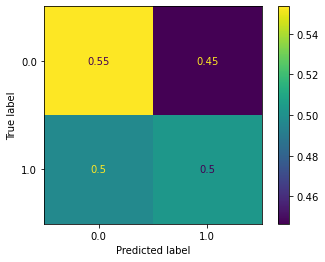

In [47]:
evaluate(dt_simple_model, X_train, X_test, y_train, y_test)

###  Simple Decision Tree Model Evaluation

Remember:

- 0 — Pet took more than 21 days to get adopted after being listed.
- 1 — Pet took less than 21 days to get adopted.

- Model is severely overfit, some tuning or different model choice is needed.
- The model is a little better than a randomguess at classifying both groups of dogs.
- It is better than my modeless understanding of 44% when predicting dogs that take longer than.

### Cat simple model

In [48]:
X = cat_model_data[used_cols]
y = cat_model_data['duration of stay']

# We add cat to the end of our training and testing variables so that we dont get mixed up with the dog model data
X_train_cat, X_hold_cat, y_train_cat, y_hold_cat = train_test_split(X, y, test_size=0.15, random_state=42)

In [49]:
#perform a second train_test_split
X = X_train_cat
y = y_train_cat

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X, y, random_state=42)

In [50]:
preprocessor_cat = preprocessor

In [51]:
X_tr_transformed_cat = preprocessor_cat.fit_transform(X_train_cat)
X_tr_transformed_cat.shape

(3789, 49)

Our cat training data has 3789 rows and 49 columns

In [52]:
preprocessor_cat.fit(X_train_cat)

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['sexname', 'basecolour', 'breedname',
                                  'intakereason']),
                                ('num',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['age(months)', 'age(years)'])])

In [53]:
cat_dt_simple_model = Pipeline(steps=[
    ('preprocessor', preprocessor_cat),
    ('classifier', DecisionTreeClassifier())
])

In [54]:
cross_validate(cat_dt_simple_model, X_train_cat, y_train_cat, return_train_score='true')

{'fit_time': array([0.02375484, 0.02500391, 0.02400517, 0.03126836, 0.03125167]),
 'score_time': array([0.00554085, 0.00500846, 0.00500131, 0.        , 0.        ]),
 'test_score': array([0.54221636, 0.5474934 , 0.56728232, 0.53562005, 0.58124174]),
 'train_score': array([0.79214781, 0.79115803, 0.78752887, 0.78785879, 0.7823219 ])}

In [55]:
cat_dt_simple_model.fit(X_train_cat, y_train_cat)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier', DecisionTreeClassifier())])

Training Scores:
Train Accuracy: 0.7735550277117973
Train Precision: 0.8469551282051282
Train Recall: 0.6131090487238979
Train F1-Score: 0.7113055181695828
ROC-AUC: 0.4902151436815937
**********
Testing Scores:
Test Accuracy: 0.564873417721519
Test Precision: 0.533816425120773
Test Recall: 0.38235294117647056
Test F1-Score: 0.44556451612903225
ROC-AUC: 0.5086212669077274


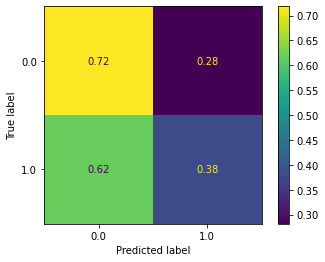

In [57]:
evaluate(cat_dt_simple_model, X_train_cat, X_test_cat, y_train_cat, y_test_cat, 'proba')

###### Remember 

- __0__ means that the cat took longer than a month to get adopted
- __1__ Means that it took less than a month to get adopted

### Simple Cat decision tree evaluation

- Better than expected at predicting cats that take longer than a month to get adopted.(which is great, thats the main point of this analysis)
- Its is not too good at classifying cats that get adopted in less than a month. 
- Overfit but our false positive rate is pretty low
- It is better than baseline modeless predictions on cats that will take longer than a month to get adopted (54%)

### Random forest Models

#### Cat Model

In [58]:
cat_forest_model = Pipeline(steps=[
    ('preprocessor', preprocessor_cat),
    ('classifier', RandomForestClassifier())
])

In [59]:
cross_validate(cat_forest_model, X_train_cat, y_train_cat, return_train_score=True)

{'fit_time': array([0.72264671, 0.74028444, 0.75005054, 0.74006033, 0.7505343 ]),
 'score_time': array([0.03125215, 0.02218676, 0.01562619, 0.01562643, 0.02299309]),
 'test_score': array([0.54221636, 0.56728232, 0.56860158, 0.54881266, 0.55746367]),
 'train_score': array([0.79214781, 0.79082811, 0.78752887, 0.78785879, 0.7823219 ])}

In [60]:
cat_forest_model.fit(X_train_cat, y_train_cat)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier', RandomForestClassifier())])

Training Scores:
Train Accuracy: 0.7735550277117973
Train Precision: 0.7867549668874172
Train Recall: 0.6890951276102089
Train F1-Score: 0.7346938775510204
ROC-AUC: 0.5184495959821126
**********
Testing Scores:
Test Accuracy: 0.571993670886076
Test Precision: 0.5364891518737672
Test Recall: 0.47058823529411764
Test F1-Score: 0.5013824884792626
ROC-AUC: 0.5565990357573323


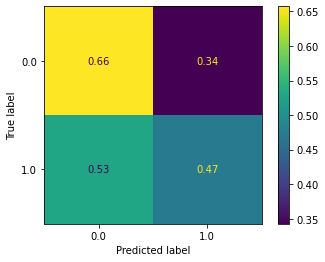

In [61]:
evaluate(cat_forest_model, X_train_cat, X_test_cat, y_train_cat, y_test_cat, 'proba')

#### Simple Random Forest Evaluation


- It performs slightly worse than our decision tree model on test data
- Its alot better at predicting which cats get adopted in less than a month. 
- It is couple points worse at predicting the cats that take longer to get adopted thant the decision tree resulting in a higher false positive rate.

#### Dog Forest Model

In [62]:
dog_forest_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

In [63]:
cross_validate(dog_forest_model, X_train, y_train, return_train_score=True)

{'fit_time': array([0.36619568, 0.36756945, 0.36624479, 0.36909151, 0.36384034]),
 'score_time': array([0.01257181, 0.02030921, 0.01762056, 0.02029085, 0.01834226]),
 'test_score': array([0.5718232 , 0.59116022, 0.54143646, 0.60220994, 0.57734807]),
 'train_score': array([0.9551105 , 0.95718232, 0.96132597, 0.95372928, 0.95925414])}

In [64]:
dog_forest_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier', RandomForestClassifier())])

Training Scores:
Train Accuracy: 0.9497237569060774
Train Precision: 0.9393346379647749
Train Recall: 0.9706774519716885
Train F1-Score: 0.9547488811536549
ROC-AUC: 0.9917595376178154
**********
Testing Scores:
Test Accuracy: 0.5778145695364238
Test Precision: 0.6338461538461538
Test Recall: 0.6023391812865497
Test F1-Score: 0.6176911544227885
ROC-AUC: 0.5943484665863131


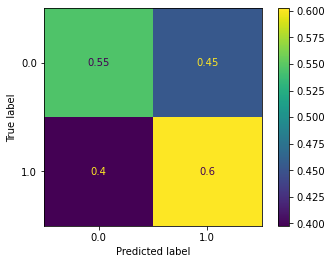

In [66]:
evaluate(dog_forest_model, X_train, X_test, y_train, y_test, 'proba')

- This model is 5 points better than the decision tree that we used for dog predictions when evaluated on accuracy score.
- Precsion score increased by 4 points.
- correctly classifies dogs that get adopted before 21 days 60% of the time.
- False positive rate is 45%.

### Knn Models

#### Dog KNN Model

In [67]:
dog_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

In [68]:
cross_validate(dog_knn, X_train, y_train, scoring='precision', return_train_score='true')

{'fit_time': array([0.0240128 , 0.0156312 , 0.01527262, 0.00513387, 0.01561165]),
 'score_time': array([0.05599141, 0.06248426, 0.04788756, 0.06251001, 0.05759788]),
 'test_score': array([0.57635468, 0.62085308, 0.56603774, 0.61616162, 0.61111111]),
 'train_score': array([0.74038462, 0.7240566 , 0.73902439, 0.72792363, 0.75367647])}

In [76]:
dog_knn.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier', KNeighborsClassifier())])

Training Scores:
Train Accuracy: 0.7259668508287292
Train Precision: 0.7404878048780488
Train Recall: 0.7674418604651163
Train F1-Score: 0.7537239324726911
ROC-AUC: 0.7974571689313262
**********
Testing Scores:
Test Accuracy: 0.5910596026490066
Test Precision: 0.6376811594202898
Test Recall: 0.6432748538011696
Test F1-Score: 0.6404657933042213
ROC-AUC: 0.5907939377706353


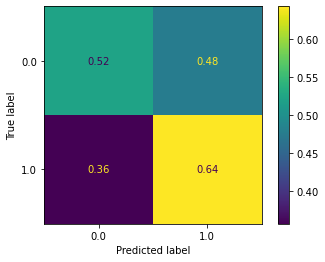

In [77]:
evaluate(dog_knn, X_train, X_test, y_train, y_test, 'proba')

##### Knn Dog Model evaluation

- Still overfit but again it is very good at predicting the dogs that get adopted on time.
- False Positive rate of 48% is slightly higher than that of the random forest model.
- Precision score is the same as the forest model but the accuracy drops 2 points 

#### Cat KNN

In [129]:
cat_knn = Pipeline(steps=[
    ('preprocessor', preprocessor_cat),
    ('classifier', KNeighborsClassifier())
])

In [130]:
cross_validate(cat_knn, X_train_cat, y_train_cat, scoring='precision', return_train_score='true')

{'fit_time': array([0.04278755, 0.01612329, 0.02099895, 0.01687479, 0.0099299 ]),
 'score_time': array([0.18906474, 0.19216108, 0.24013329, 0.20212936, 0.1501081 ]),
 'test_score': array([0.51987768, 0.50769231, 0.51428571, 0.485623  , 0.49707602]),
 'train_score': array([0.65539452, 0.67412935, 0.64912281, 0.67833333, 0.64889566])}

In [131]:
cat_knn.fit(X_train_cat, y_train_cat)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier', KNeighborsClassifier())])

Training Scores:
Train Accuracy: 0.6637635259963051
Train Precision: 0.6466753585397653
Train Recall: 0.5754060324825986
Train F1-Score: 0.6089625537139348
ROC-AUC: 0.5398962275653381
**********
Testing Scores:
Test Accuracy: 0.5443037974683544
Test Precision: 0.502127659574468
Test Recall: 0.4083044982698962
Test F1-Score: 0.45038167938931295
ROC-AUC: 0.545092852997634


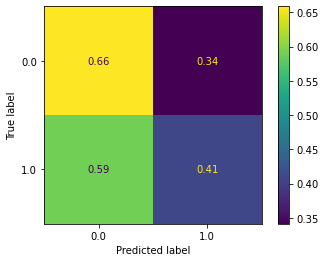

In [132]:
evaluate(cat_knn, X_train_cat, X_test_cat, y_train_cat, y_test_cat, 'proba')

#### Cat KNN Evaluation

- Lower false positive rate of 34%
- It is pretty good at classifying cats that take longer than a month to get adopted
- precision and accuracy scores on test data are low only around 50 percent
- knn model is also performing better on training data

### Logistic Regression

#### Dog Logistic model

In [83]:
dog_log = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [84]:
cross_validate(dog_log, X_train, y_train, scoring='precision', return_train_score='true')

{'fit_time': array([0.07226014, 0.0578351 , 0.05601168, 0.05861235, 0.04978085]),
 'score_time': array([0.00799274, 0.00800991, 0.0082705 , 0.00802779, 0.00802112]),
 'test_score': array([0.63346614, 0.63274336, 0.5877551 , 0.59148936, 0.61777778]),
 'train_score': array([0.6448203 , 0.64444444, 0.65263158, 0.65356004, 0.65729167])}

In [85]:
dog_log.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier', LogisticRegression())])

Training Scores:
Train Accuracy: 0.6441988950276243
Train Precision: 0.6463104325699746
Train Recall: 0.7704752275025278
Train F1-Score: 0.7029520295202952
ROC-AUC: 0.6922013032517251
**********
Testing Scores:
Test Accuracy: 0.6307947019867549
Test Precision: 0.6454767726161369
Test Recall: 0.7719298245614035
Test F1-Score: 0.70306258322237
ROC-AUC: 0.6682569974554706


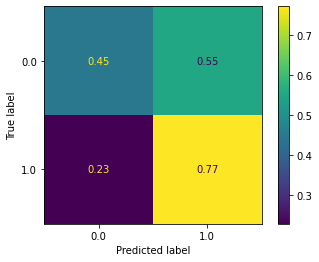

In [87]:
evaluate(dog_log, X_train, X_test, y_train, y_test, 'proba')

##### Dog Logistic Regression Evaluation

- Very similar to our other dog models when looking at false positive rates
- The good thing about this model is that it is not overfit, it performs similarly on both test and training data
- This is the best overall model with AUC score of 66 but it also has the highest false positive rate out of all of the dog models.

##### Cat Logistic Regression Model 

In [133]:
cat_log = Pipeline(steps=[
    ('preprocessor', preprocessor_cat),
    ('classifier', LogisticRegression())
])

In [134]:
cross_validate(cat_log, X_train_cat, y_train_cat, scoring='precision', return_train_score='true')

{'fit_time': array([0.08212852, 0.0853188 , 0.06847763, 0.06971097, 0.07657361]),
 'score_time': array([0.01606917, 0.00563216, 0.0160234 , 0.0079999 , 0.0080111 ]),
 'test_score': array([0.54347826, 0.54696133, 0.55778894, 0.56603774, 0.57446809]),
 'train_score': array([0.61138614, 0.59574468, 0.57718894, 0.6       , 0.60892388])}

In [135]:
cat_log.fit(X_train_cat, y_train_cat)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier', LogisticRegression())])

Training Scores:
Train Accuracy: 0.5964634468197414
Train Precision: 0.6040554962646745
Train Recall: 0.32830626450116007
Train F1-Score: 0.4254039834648628
ROC-AUC: 0.5426500272793665
**********
Testing Scores:
Test Accuracy: 0.5775316455696202
Test Precision: 0.5666666666666667
Test Recall: 0.3235294117647059
Test F1-Score: 0.41189427312775334
ROC-AUC: 0.5770724521226731


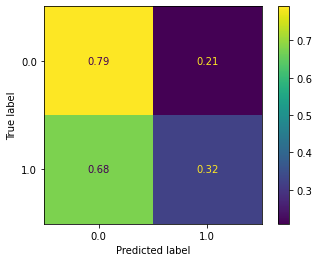

In [136]:
evaluate(cat_log, X_train_cat, X_test_cat, y_train_cat, y_test_cat, 'proba')

#### Cat Logistic Regression evaluation

- Logistic Regression gives us our lowest false positive rate for cats, we got it down to almost 20 percent here.
- Also the model performs similarly on training and test data.
- This is our best model yet for accurately predicting which cats wont be adopted within a month.
- Performs similarly on testing and training data

### XGBboost Models

#### Dog Model 

In [92]:
xgb_dog = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

In [93]:
cross_validate(xgb_dog, X_train, y_train, scoring='precision', return_train_score='true')

{'fit_time': array([0.11347342, 0.09925318, 0.08000684, 0.08303618, 0.07527256]),
 'score_time': array([0.02591968, 0.00800085, 0.00800014, 0.01679206, 0.01674318]),
 'test_score': array([0.63084112, 0.60538117, 0.60986547, 0.68341709, 0.63316583]),
 'train_score': array([0.83023256, 0.83548766, 0.8242142 , 0.8242142 , 0.82      ])}

In [94]:
xgb_dog.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier',
                 XGBClassifier(base_...
          

Training Scores:
Train Accuracy: 0.8243093922651934
Train Precision: 0.8144329896907216
Train Recall: 0.8786653185035389
Train F1-Score: 0.8453307392996109
ROC-AUC: 0.9100889319666146
**********
Testing Scores:
Test Accuracy: 0.5860927152317881
Test Precision: 0.6270718232044199
Test Recall: 0.6637426900584795
Test F1-Score: 0.6448863636363636
ROC-AUC: 0.6266572920851747


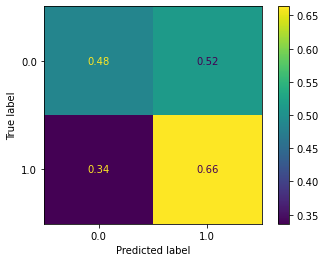

In [96]:
evaluate(xgb_dog, X_train, X_test, y_train, y_test, 'proba')

##### Model Evaluation

- Better at classifying dogs that get adopted in less than 21 days.
- False Positive rate is 52%
- Very similar to the logistic model, but alot more overfit.

### Cat XGBboost Model

In [137]:
xgb_cat = Pipeline(steps=[
    ('preprocessor', preprocessor_cat),
    ('classifier', XGBClassifier())
])

In [138]:
cross_validate(xgb_cat, X_train_cat, y_train_cat, scoring='precision', return_train_score='true')

{'fit_time': array([0.17122197, 0.12735915, 0.11184669, 0.10400653, 0.10637021]),
 'score_time': array([0.01999092, 0.01864433, 0.01615477, 0.0155859 , 0.01814604]),
 'test_score': array([0.53281853, 0.51153846, 0.56862745, 0.51485149, 0.55102041]),
 'train_score': array([0.76328052, 0.74303684, 0.72687225, 0.73539519, 0.73487544])}

In [139]:
xgb_cat.fit(X_train_cat, y_train_cat)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier',
                 XGBClassifier(base_...
          

Training Scores:
Train Accuracy: 0.7102137767220903
Train Precision: 0.7325408618127786
Train Recall: 0.5719257540603249
Train F1-Score: 0.6423452768729643
ROC-AUC: 0.5135737940734191
**********
Testing Scores:
Test Accuracy: 0.5783227848101266
Test Precision: 0.5507900677200903
Test Recall: 0.42214532871972316
Test F1-Score: 0.4779627815866797
ROC-AUC: 0.5327887147895183


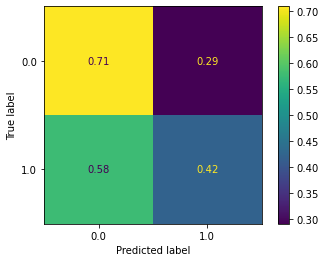

In [140]:
evaluate(xgb_cat, X_train_cat, X_test_cat, y_train_cat, y_test_cat, 'proba')

#### Model Evaluation

- Higher false positive rate than the Logistic Model
- Model is overfit
- Has a higher true positive rate than the Logistic Model, but we are focusing on flase positives because we want the identify the pets that really need help getting adopted.

## Model Tuning/Select Final Models

+ __Dog Predictions:__  The model that performed the best overall was **Logistic Regression**, It didnt have the lowest false positive rate, but tuning it for the best precision score, might result in the best model.
+ __Cat Predictions:__  gave us the lowest false positive  was **Logistic Regression** and it performed equally on both training and testing data, tuning it for accuracy might increase the True positive ratio. 

#### Dog Model

In [103]:
param_grid = [
    {'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear', 'lbfgs']}]

gs_log = GridSearchCV(dog_log, param_grid=log_param_grid, scoring='precision', verbose=1, cv=5, n_jobs=-1)

gs_log.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    2.1s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['sexname',
                                                                          'basecolour',
                                                                          'breedname',
                                                                          'intakereason']),
                                                                        ('num',
                                                                         Pipeline(steps=[(

In [104]:
gs_log.best_params_

{'classifier__C': 1438.44988828766,
 'classifier__penalty': 'l2',
 'classifier__solver': 'lbfgs'}

In [105]:
gs_log.best_score_

0.621534134947902

In [106]:
dog_log_tuned = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l2', C=1438.44988828766))
])

In [108]:
cross_validate(dog_log_tuned, X_train, y_train, scoring='precision', return_train_score='true')

{'fit_time': array([0.06220675, 0.07782769, 0.06273007, 0.07214212, 0.06274199]),
 'score_time': array([0.00799918, 0.        , 0.01562881, 0.        , 0.        ]),
 'test_score': array([0.63948498, 0.63636364, 0.60504202, 0.60352423, 0.62325581]),
 'train_score': array([0.64403067, 0.64686469, 0.65798046, 0.66555556, 0.65909091])}

In [109]:
dog_log_tuned.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier', LogisticRegression(C=1438.44988828766))])

Training Scores:
Train Accuracy: 0.638121546961326
Train Precision: 0.6462346760070052
Train Recall: 0.7462082912032356
Train F1-Score: 0.6926325668700141
ROC-AUC: 0.6938787071920233
**********
Testing Scores:
Test Accuracy: 0.6307947019867549
Test Precision: 0.6506329113924051
Test Recall: 0.7514619883040936
Test F1-Score: 0.6974219810040706
ROC-AUC: 0.6665829650462033


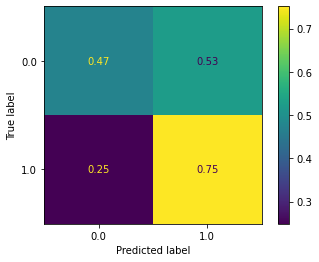

In [112]:
evaluate(dog_log_tuned, X_train, X_test, y_train, y_test, 'proba')

## Final model evaluation for dog adoptions

- tuning the model only dropped the false positive rate by 2 points.
- This model is 3 points better than our basic modeless understanding
- the model is not overfit so it should perform similarly on unseen data.
- This model can still be useful because it is decently accurate at classifying dogs that do not need as much help getting adopted, now those resources can be used on the dogs that do need the help.

#### Test this model on the holdout set

Training Scores:
Train Accuracy: 0.638121546961326
Train Precision: 0.6462346760070052
Train Recall: 0.7462082912032356
Train F1-Score: 0.6926325668700141
ROC-AUC: 0.6938787071920233
**********
Testing Scores:
Test Accuracy: 0.6276346604215457
Test Precision: 0.6448275862068965
Test Recall: 0.7695473251028807
Test F1-Score: 0.7016885553470918
ROC-AUC: 0.6665829650462033


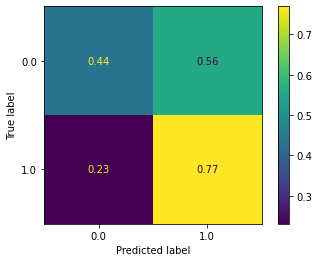

In [113]:
evaluate(dog_log_tuned, X_train, X_hold, y_train, y_hold, 'proba')

Performs very similar on the holdout set, true positive rate went up 2 points which is good but the false positive rate also went up 3 points. Overall it should work well on new data.

### Cat Model/ Final Model Selection

- The Logistic Regression Model gave us our best results without being overfit.
- It had a very low false positive rate of only 21%
- but its true positive rate was also low.
- tuning this model for an higher accuracy might give us a better overall model.

In [114]:
cat_log.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'classifier', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__cat', 'preprocessor__num', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__onehotencoder', 'preprocessor__cat__onehotencoder__categories', 'preprocessor__cat__onehotencoder__drop', 'preprocessor__cat__onehotencoder__dtype', 'preprocessor__cat__onehotencoder__handle_unknown', 'preprocessor__cat__onehotencoder__sparse', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__standardscaler', 'preprocessor__num__standardscaler__copy', 'preprocessor__num__standardscaler__with_mean', 'preprocessor__num__standardscaler__with_std', 'classifier__C', 'classifier__class_weight', 'classifier__dual', 'classifier__fit_intercept', 'c

In [117]:
param_grid = [
    {'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear', 'lbfgs']}]

gs_log_cat = GridSearchCV(cat_log, param_grid=log_param_grid, scoring='accuracy', verbose=1, cv=5, n_jobs=-1)

gs_log_cat.fit(X_train_cat, y_train_cat)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    2.8s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['sexname',
                                                                          'basecolour',
                                                                          'breedname',
                                                                          'intakereason']),
                                                                        ('num',
                                                                         Pipeline(steps=[(

In [118]:
gs_log_cat.best_params_

{'classifier__C': 0.08858667904100823,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear'}

In [119]:
gs_log_cat.best_score_

0.5816847505951489

In [120]:
cat_log_tuned = Pipeline(steps=[
    ('preprocessor', preprocessor_cat),
    ('classifier', LogisticRegression(penalty= 'l1', C=0.08858667904100823, solver='liblinear'))
])

In [121]:
cross_validate(cat_log_tuned, X_train_cat, y_train_cat, scoring='precision', return_train_score='true')

{'fit_time': array([0.02402639, 0.02399898, 0.02425241, 0.01541114, 0.01564598]),
 'score_time': array([0.00932693, 0.01600099, 0.0016942 , 0.01912761, 0.01562595]),
 'test_score': array([0.58974359, 0.55333333, 0.64655172, 0.60992908, 0.6119403 ]),
 'train_score': array([0.60946746, 0.5918958 , 0.59686888, 0.61185468, 0.61172161])}

In [122]:
cat_log_tuned.fit(X_train_cat, y_train_cat)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier',
                 LogisticRegression(C=0.0885866790

Training Scores:
Train Accuracy: 0.5832673528635524
Train Precision: 0.6070901033973413
Train Recall: 0.23839907192575405
Train F1-Score: 0.3423573511037068
ROC-AUC: 0.5275269129732786
**********
Testing Scores:
Test Accuracy: 0.5632911392405063
Test Precision: 0.5537190082644629
Test Recall: 0.23183391003460208
Test F1-Score: 0.32682926829268294
ROC-AUC: 0.5606892549439757


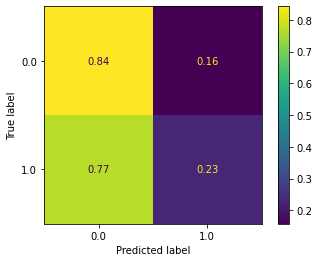

In [123]:
evaluate(cat_log_tuned, X_train_cat, X_test_cat, y_train_cat, y_test_cat, 'proba')

- While this model has the lowest false positive rate yet, The true positive rate is extremely low, so we dont really know which cats are really thriving in the shelter system. 
- We will use the untuned logistic Regression model as our final model because there is a little more balance.

## Final Model Evaluation on Cat Adoptions
- Test data on the holdout set

Training Scores:
Train Accuracy: 0.5964634468197414
Train Precision: 0.6040554962646745
Train Recall: 0.32830626450116007
Train F1-Score: 0.4254039834648628
**********
Testing Scores:
Test Accuracy: 0.5852017937219731
Test Precision: 0.5879828326180258
Test Recall: 0.3333333333333333
Test F1-Score: 0.42546583850931674


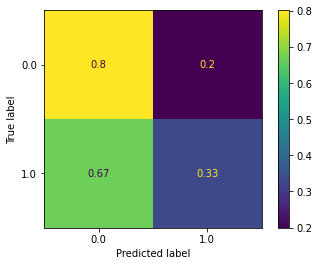

In [124]:
evaluate(cat_log, X_train_cat, X_hold_cat, y_train_cat, y_hold_cat)

+ It correctly classifies cats that take longer than a month to take adopted 80 percent of the time 
+ But only correctly classifies cats that get adopted in less than a month 33% of the time
+ This model has a vey low false positive rate(20%)

## Recommendations

## Conclusion

- The models still needs work but it can be used in conjunction with your domain knowledge to efficiently use resources to aid the dogs and cats that need the most help getting adopted. 

- Our cat model is very good at predicting which cats need help getting adopted in a timely manner but not very good at prediciting the cats that get adopted in a timely manner.

- The dog model is the opposite, it is very good at classifying the dogs that get adopted on time, but not too good at classifying the dogs that really need help.


- Our cat model will still misclassify cats that need help getting adopted 21% of the time.

## Future Work

- See if this model gets similar results on other shelters
- Analyze how the time of year that the animal entered the shelter effects adoption speed
- Experiment with the features and engineer them in different ways to improve scores
- Analyze how a pet's behaviour affects adoption speed